In [ ]:
!pip -q install "gymnasium[toy-text]" numpy matplotlib


In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

SEED = 42
rng = np.random.default_rng(SEED)

env = gym.make("Taxi-v3")
env.reset(seed=SEED)
env.action_space.seed(SEED)

# Número de estados (nesse caso sao 500)
nS = env.observation_space.n

# Número de ações (nesse caso sao 6)
nA = env.action_space.n


# Isso aqui seria a Q-Table
# Inicia tudo com 0 e tem estados ação x Estados
Q = np.zeros((nS, nA), dtype=np.float32)

# hiperparâmetros iniciais
episodes = 30_000
alpha = 0.1
gamma = 0.99
eps, eps_end, eps_decay = 1.0, 0.05, 0.9995

print("States:", nS, "Actions:", nA)
print({"episodes": episodes, "alpha": alpha, "gamma": gamma, "eps_start": eps, "eps_end": eps_end, "eps_decay": eps_decay})


States: 500 Actions: 6
{'episodes': 30000, 'alpha': 0.1, 'gamma': 0.99, 'eps_start': 1.0, 'eps_end': 0.05, 'eps_decay': 0.9995}


In [ ]:
returns = [] # Essa lista serve pra guardar o retorno total
lengths = [] # Lista pra gaurdar quantos passos durou cada ep

# Loop de treinamento
for ep in range(episodes):

    # Resetar a cada loop
    s, _ = env.reset()

    done = False

    # Retorno acumulado
    G = 0.0

    # Passos ne
    steps = 0



    while not done:

        # Política epilson greedy

        # Essa aqui é a parte que decide se vai explorar ou ganhar pontos

        # Aqui seria pra exploração
        if rng.random() < eps:
            a = env.action_space.sample()

        # Aqui seria pra ganhar o máximo de pontos
        else:
            a = int(np.argmax(Q[s]))

        # s2 = próxmio espaço
        # r = recompensa e já e calculado pelo ambiente
        # terminated = objetivo alcançado
        # truncated = limite alcançado
        s2, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated


        # Fórmula de atualização do Q learning
        Q[s, a] += alpha * (r + gamma * np.max(Q[s2]) - Q[s, a])

        # Atualiza estado
        s = s2

        # Coloca na recompensa final
        G += r

        # Incrementa passos
        steps += 1

    # Decaimento do epilson (estudar mais)
    eps = max(eps_end, eps * eps_decay)

    # Armazena as coisas
    returns.append(G)
    lengths.append(steps)

print("Treino concluído.")
print("Retorno médio (últimos 500):", float(np.mean(returns[-500:])))
print("Passos médios (últimos 500):", float(np.mean(lengths[-500:])))


Treino concluído.
Retorno médio (últimos 500): 5.452
Passos médios (últimos 500): 13.838


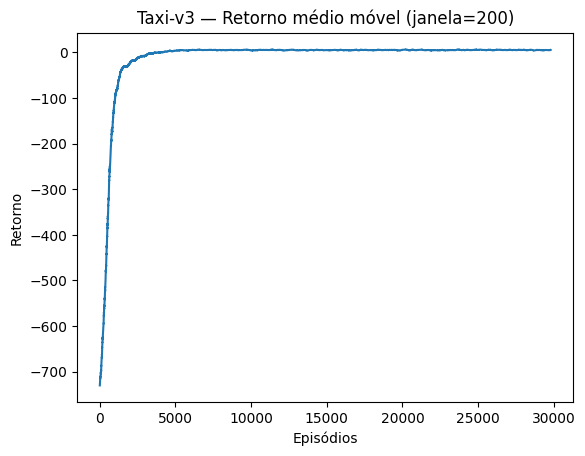

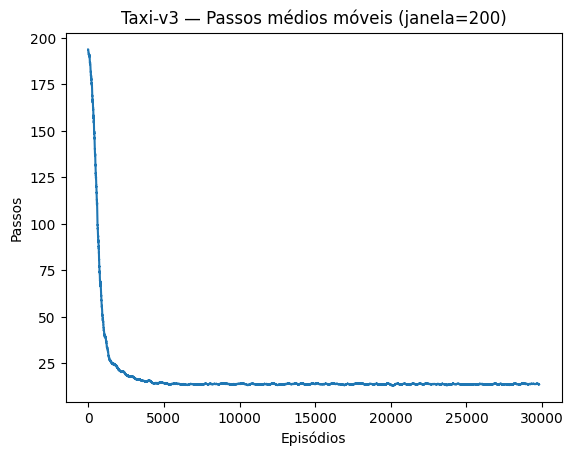

In [ ]:
def moving_avg(x, w=200):
    x = np.array(x, dtype=np.float32)
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode="valid")

plt.figure()
plt.plot(moving_avg(returns, 200))
plt.title("Taxi-v3 — Retorno médio móvel (janela=200)")
plt.xlabel("Episódios")
plt.ylabel("Retorno")
plt.show()

plt.figure()
plt.plot(moving_avg(lengths, 200))
plt.title("Taxi-v3 — Passos médios móveis (janela=200)")
plt.xlabel("Episódios")
plt.ylabel("Passos")
plt.show()


In [ ]:
# Essa função serve pra avaliar a política aprendida (Essa parte foi com IA mesmo)
def evaluate(Q, n=300, seed=123):
    env_eval = gym.make("Taxi-v3")
    env_eval.reset(seed=seed)
    scores, steps_list = [], []

    for _ in range(n):
        s, _ = env_eval.reset()
        done = False
        G = 0
        steps = 0
        while not done:
            a = int(np.argmax(Q[s]))
            s, r, terminated, truncated, _ = env_eval.step(a)
            done = terminated or truncated
            G += r
            steps += 1
        scores.append(G)
        steps_list.append(steps)

    return float(np.mean(scores)), float(np.std(scores)), float(np.mean(steps_list))

mean, std, mean_steps = evaluate(Q, 300)
print("Eval retorno:", mean, "+/-", std)
print("Eval passos médios:", mean_steps)


Eval retorno: 8.026666666666667 +/- 2.641834379534207
Eval passos médios: 12.973333333333333


In [ ]:
# Essa parte vi em outro projeto que vi no github achei legal

env_vis = gym.make("Taxi-v3", render_mode="ansi")

s, _ = env_vis.reset(seed=7)
done = False

print(env_vis.render())
while not done:
    a = int(np.argmax(Q[s]))
    s, r, terminated, truncated, _ = env_vis.step(a)
    done = terminated or truncated
    print(env_vis.render())

print("Reward final:", r)


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | :_:G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|

In [ ]:
print("Q min:", float(Q.min()), "Q max:", float(Q.max()), "Q mean:", float(Q.mean()))
# quantos estados já têm alguma preferência aprendida (diferença entre melhor e pior ação)
pref = (Q.max(axis=1) - Q.min(axis=1))
print("Estados com preferência > 0:", int(np.sum(pref > 0)), "/", nS)


Q min: -17.337026596069336 Q max: 19.99999237060547 Q mean: -0.5701421499252319
Estados com preferência > 0: 400 / 500


In [ ]:
import json
import numpy as np

np.save("Q_table_taxi.npy", Q)

results = {
    "environment": "Taxi-v3",
    "algorithm": "Q-Learning",
    "episodes": episodes,
    "alpha": alpha,
    "gamma": gamma,
    "epsilon_start": 1.0,
    "epsilon_end": eps_end,
    "epsilon_decay": eps_decay,
    "final_epsilon": eps,
    "train_return_last_500": float(np.mean(returns[-500:])),
    "train_steps_last_500": float(np.mean(lengths[-500:])),
    "eval_return_mean": mean,
    "eval_return_std": std,
    "eval_steps_mean": mean_steps,
}

with open("results_taxi_qlearning.json", "w") as f:
    json.dump(results, f, indent=4)

print("Arquivos salvos:")
print("- Q_table_taxi.npy")
print("- results_taxi_qlearning.json")


Arquivos salvos:
- Q_table_taxi.npy
- results_taxi_qlearning.json


In [ ]:
print("="*60)
print("RESUMO FINAL — Q-LEARNING (Taxi-v3)")
print("="*60)
for k, v in results.items():
    print(f"{k:25s}: {v}")
print("="*60)


RESUMO FINAL — Q-LEARNING (Taxi-v3)
environment              : Taxi-v3
algorithm                : Q-Learning
episodes                 : 30000
alpha                    : 0.1
gamma                    : 0.99
epsilon_start            : 1.0
epsilon_end              : 0.05
epsilon_decay            : 0.9995
final_epsilon            : 0.05
train_return_last_500    : 5.452
train_steps_last_500     : 13.838
eval_return_mean         : 8.026666666666667
eval_return_std          : 2.641834379534207
eval_steps_mean          : 12.973333333333333
